# Case study

In [1]:
import numpy as np
import pandas as pd
import re
import sys

In [2]:
DATADIR = "../usb/releases/20201018/"
DROPOUTDATADIR = "../usb/releases/20200302/"
CLIENTSFILE = "clients.csv.gz"
DROPOUTFILE = "dropout.csv.gz"
ANSWERID = "answerId_normalized"
ANSWERIDORIGINAL = "answerId_original"
ANSWERTEXT = "answerText"
ANSWERTITLE = "answerTitle"
CLIENT = "client"
CLIENTID = "clientID"
DROPOUT = "dropout"
QUESTIONNUMBER = "questionNumber"
REMOVED = "REMOVED"
COMPLETERCODE = "2"
DROPOUTCODE = "1"

In [3]:
def read_dropout_ids():
    dropout = pd.read_csv(DROPOUTDATADIR+DROPOUTFILE)
    dropout_ids = list(dropout[dropout[DROPOUT]==DROPOUTCODE][CLIENTID])
    completer_ids = list(dropout[dropout[DROPOUT]==COMPLETERCODE][CLIENTID])
    return(dropout_ids,completer_ids)

In [4]:
dropout_ids,completer_ids = read_dropout_ids()
len(dropout_ids),len(completer_ids)

(653, 359)

## Task 1: compare metadata of dropouts and completers

In [5]:
GENDER = "geslacht"
AGE = "leeftijd"
EDUCATION = "opleidng"
DAY1 = "dag1"
MAN = "Man"
WOMAN = "Vrouw"
ANSWER = "answer"
COUNT = "count"
YESNO = "YESNO"
YESNOIDS = ["dagritme","dsm2","dsm3","dsm4","dsm5","dsm6","dsm7","dsm8","dsm9","dsm11",
            "medicijn","drugs","eetdrang","insult","delirium","psych","tabak","canna",
            "coca","speed","xtc","ghb","opiat","sleep","gok","behversl","halluci",
            "suicide","wanen","benniet"]
COLUMNS = [{ANSWER:answer, COUNT:1} for answer in [GENDER,EDUCATION,DAY1,AGE]+YESNOIDS]
CONVERSION = { GENDER: {WOMAN:0,MAN:1},
               EDUCATION: {"Basisschool":0,"LBO/MAVO":1,"MBO":2,"HAVO/VWO":3,"HBO":4,"WO":5,"REMOVED":np.nan},
               YESNO: {"Nee":0,"Ja":1}}

def make_numeric(df,column_names):
    row_nbrs = {}
    data_table = []
    questionnaire_types = {}
    column_name_ids = {column_names[i]:i for i in range(0,len(column_names))}
    answer_text_to_digit = {}
    for i in range(0,len(df)):
        row = df.iloc[i]
        client_id = row[CLIENT]
        if not client_id in row_nbrs:
            row_nbrs[client_id] = len(data_table)
            data_table.append(len(column_names)*[np.nan])
        answer_id = row[ANSWERID]
        answer_text = cleanup_answer_text(row[ANSWERTEXT])
        if answer_id in column_names and not pd.isna(answer_text) and answer_text != "removed":
            if answer_id == EDUCATION:
                data_table[-1][column_name_ids[answer_id]] = CONVERSION[EDUCATION][answer_text]
            elif answer_id == AGE:
                try:
                    data_table[-1][column_name_ids[answer_id]] = int(re.sub("\D","",answer_text))
                except:
                    pass
            elif answer_id in answer_text_to_digit and answer_text in answer_text_to_digit[answer_id]:
                data_table[-1][column_name_ids[answer_id]] = answer_text_to_digit[answer_id][answer_text]
            elif not answer_id in answer_text_to_digit:
                answer_text_to_digit[answer_id] = { answer_text: 0 }
                data_table[-1][column_name_ids[answer_id]] = answer_text_to_digit[answer_id][answer_text]
            elif answer_id in answer_text_to_digit and len(answer_text_to_digit[answer_id]) == 1:
                answer_text_to_digit[answer_id][answer_text] = 1
                data_table[-1][column_name_ids[answer_id]] = answer_text_to_digit[answer_id][answer_text]
            else:
                print(f"cannot happen: {answer_id} {answer_text} {len(answer_text_to_digit[answer_id])}")
    return(data_table)

In [6]:
def read_data(dropout_ids,completer_ids):
    client_data = pd.read_csv(DATADIR+CLIENTSFILE)
    dropout_data = client_data[client_data[CLIENT].isin(dropout_ids)]
    completer_data = client_data[client_data[CLIENT].isin(completer_ids)]
    return(dropout_data,completer_data)

In [7]:
dropout_data,completer_data = read_data(dropout_ids,completer_ids)
all_data = pd.concat([dropout_data,completer_data])

In [8]:
def verify_data_completeness(dropout_data,completer_data,dropout_ids,completer_ids):
    dropout_data_ids = list(dropout_data[CLIENT])
    for client_id in dropout_ids:
        if client_id not in dropout_data_ids:
            print(f"missing dropout client id: {client_id}")

    completer_data_ids = list(completer_data[CLIENT])
    for client_id in completer_ids:
        if client_id not in completer_data_ids:
            print(f"missing completer client id: {client_id}")
            
verify_data_completeness(dropout_data,completer_data,dropout_ids,completer_ids)

missing dropout client id: AdB1263
missing dropout client id: AdB1469


In [77]:
def get_answer_values(dropout_data, completer_data, column_name):
    nbr_of_dropouts = len(dropout_data.groupby("client").groups)
    nbr_of_completers = len(completer_data.groupby("client").groups)
    dropout_values = pd.DataFrame(dropout_data[dropout_data["answerId_normalized"]==column_name],columns=["answerText"]).groupby("answerText").size()
    completer_values = pd.DataFrame(completer_data[completer_data["answerId_normalized"]==column_name],columns=["answerText"]).groupby("answerText").size()
    nbr_of_missing = nbr_of_dropouts+nbr_of_completers
    answer_values = {}
    for key in dropout_values.index:
        if not key in dropout_values:
            dropout_values[key] = 0
        if not key in completer_values:
            completer_values[key] = 0
        answer_values[key] = dropout_values[key]+completer_values[key]
        nbr_of_missing -= dropout_values[key]+completer_values[key]
    answer_values["MISSING"] = nbr_of_missing
    return(answer_values)

### 1.1 Experiment with binary answer classes

In [9]:
GESLACHT = "geslacht"
GESLACHT0 = "geslacht0"
GESLACHTT0 = "geslachtt0"
NONQUESTIONS = "^(goTo[0-9]|ltgeslacht1|doel)$"
EXCEPTIONANSWERID = "mdoel"

def cleanup_answer_text(text):
    if pd.isna(text): return(text)
    text = str(text).lower()
    text = re.sub("\s+"," ",text)
    text = text.strip()
    return(text)

def normalize_answer_id(answer_id, first_answer_id):
    if first_answer_id == GESLACHT: 
        new_answer_id = answer_id
    elif first_answer_id == GESLACHT0:
        if re.search("0h$",answer_id):
            new_answer_id = re.sub("0h$","h",answer_id)
        else:
            new_answer_id = re.sub("0$","",answer_id)
    elif first_answer_id == GESLACHTT0: 
        new_answer_id = re.sub("t0$","",answer_id)
    else: 
        sys.exit(f"unknown first answer id: {first_answer_id}!")
    if re.search("^(goTo[0-9]|ltgeslacht1|doel)$",answer_id):
        return("")
    if (first_answer_id != GESLACHT and new_answer_id == answer_id and 
        not answer_id == EXCEPTIONANSWERID and not re.search(NONQUESTIONS,answer_id)):
        sys.exit(f"first answer id {first_answer_id} did not change {answer_id}!")
    return(new_answer_id)

In [10]:
def find_binary_answer_classes(dropout_data,completer_data):
    answer_texts = {}
    data = pd.concat([dropout_data,completer_data])
    for i in range(0,len(data)):
        client_id = data.iloc[i][CLIENT]
        answer_text = cleanup_answer_text(data.iloc[i][ANSWERTEXT])
        answer_title = cleanup_answer_text(data.iloc[i][ANSWERTITLE])
        if pd.isna(answer_title): answer_title = ""
        answer_id = str(data.iloc[i][ANSWERID])
        answer_key = answer_id+"#"+answer_title
        if not answer_key in answer_texts.keys(): answer_texts[answer_key] = []
        if not answer_text in answer_texts[answer_key] and not pd.isna(answer_text) and not answer_text == "removed":
            answer_texts[answer_key].append(answer_text)
    results = []
    for answer_key in answer_texts:
        if len(answer_texts[answer_key]) == 2: 
            results.append((answer_key,answer_texts[answer_key]))
    return(results)

In [11]:
results = find_binary_answer_classes(dropout_data,completer_data)

In [84]:
useful_column_names = []
for column_name in [re.sub("#.*$","",results[i][0]) for i in range(0,len(results))]:
    print("#####", column_name)
    answer_values = get_answer_values(dropout_data, completer_data, column_name)
    for answer_value in answer_values:
        print(answer_values[answer_value], answer_value)
    if sum([answer_values[answer_value] for answer_value in answer_values if answer_value == "MISSING" or answer_value == "REMOVED"]) < 100:
        useful_column_names.append(column_name)

In [81]:
dropout_table = make_numeric(dropout_data[dropout_data[ANSWERID].isin([COLUMNS[i][ANSWER] for i in range(0,len(COLUMNS))])], useful_column_names)
completer_table = make_numeric(completer_data[completer_data[ANSWERID].isin([COLUMNS[i][ANSWER] for i in range(0,len(COLUMNS))])], useful_column_names)

In [82]:
from sklearn.feature_selection import f_classif
import numpy as np
from sklearn.impute import SimpleImputer

def run_anova(dropout_table,completer_table):
    X = dropout_table+completer_table
    y = len(dropout_table)*[DROPOUTCODE]+len(completer_table)*[COMPLETERCODE]
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(X)
    F,p_values = f_classif(imp.transform(X),y)
    return(p_values)

def column_average(table,column_id):
    return(np.average([row[column_id] for row in table if not np.isnan(row[column_id])]))

def sort_p_values(p_values,column_names,dropout_table,completer_table):
    return({column_names[i][ANSWER]:(p_values[i],column_names[i][COUNT],column_average(completer_table,i),column_average(dropout_table,i)) 
            for i in sorted(range(0,len(p_values)),key=lambda i:p_values[i])})

In [83]:
p_values = run_anova(dropout_table,completer_table)
sort_p_values(p_values,COLUMNS,dropout_table,completer_table)

/home/erikt/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/erikt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'dsm3': (2.9135825385975323e-154,
  1,
  0.28205128205128205,
  0.34169278996865204),
 'opleidng': (1.1743989814453627e-51,
  1,
  0.7891737891737892,
  0.31347962382445144),
 'dsm4': (2.2330370574930088e-43, 1, 0.1282051282051282, 0.8605015673981191),
 'dsm6': (2.3919162974087357e-21, 1, 0.6296296296296297, 0.5611285266457681),
 'dsm7': (2.3418975342051173e-09, 1, 0.6752136752136753, 0.3667711598746082),
 'dsm9': (0.0016659191960769453, 1, 0.4444444444444444, 0.6394984326018809),
 'geslacht': (0.004705672286053419,
  1,
  0.38997214484679665,
  0.4823348694316436),
 'dsm8': (0.015039984707418842, 1, nan, nan),
 'dsm5': (0.03650274804418443, 1, 0.7692307692307693, 0.33072100313479624),
 'dag1': (0.036976955997104, 1, nan, nan),
 'dsm11': (0.05119417140323804, 1, 0.06017191977077364, 0.10658307210031348),
 'dsm2': (0.054631345137410435, 1, 0.14, 0.14937106918238993),
 'medicijn': (0.14519363501303997,
  1,
  0.11396011396011396,
  0.19122257053291536),
 'leeftijd': (0.27449463245039607

### 1.2 Experiment with all answer classes

In [16]:
MINANSWERCOUNT = 10
MAXPVALUE = 0.01
ANSWER = "answer"
COUNT = "count"

def get_binary_answers(data):
    answers_per_client = {}
    for i in range(0,len(data)):
        client_id = data.iloc[i][CLIENT]
        if not client_id in answers_per_client:
            answers_per_client[client_id] = []
        answer_id = str(data.iloc[i][ANSWERID])
        if re.search(NONQUESTIONS,answer_id): continue
        answer_text = cleanup_answer_text(data.iloc[i][ANSWERTEXT])
        answer_title = cleanup_answer_text(data.iloc[i][ANSWERTITLE])
        if not pd.isna(answer_text): # and answer_text != "removed":
            if pd.isna(answer_title): answer_title = ""
            answers_per_client[client_id].append(answer_id+"#"+answer_title+"#"+answer_text)
    return(answers_per_client)

def count_answers(binary_answers):
    answer_counts = {}
    for client_id in binary_answers:
        for answer in binary_answers[client_id]:
            if answer in answer_counts:
                answer_counts[answer] += 1
            else:
                answer_counts[answer] = 1
    return({answer:answer_counts[answer] for answer in sorted(answer_counts.keys(),key=lambda a:answer_counts[a],reverse=True)})

def make_binary_table(data,binary_answers):
    answer_counts = count_answers(binary_answers)
    binary_table = []
    answers_used = []
    for client_id in data[CLIENT].unique():
        binary_table.append([])
        for answer in answer_counts:
            if answer_counts[answer] >= MINANSWERCOUNT:
                if answer in binary_answers[client_id]:
                    binary_table[-1].append(1)
                else:
                    binary_table[-1].append(0)
    for answer in answer_counts:
        if answer_counts[answer] >= MINANSWERCOUNT:
            answers_used.append({ANSWER:answer, COUNT:answer_counts[answer]})
    return(binary_table, answers_used)

def convert_data_to_binary(dropout_data,completer_data):
    all_data = pd.concat([dropout_data,completer_data])
    binary_answers = get_binary_answers(all_data)
    dropout_table_binary, answers_used = make_binary_table(dropout_data,binary_answers)
    completer_table_binary, answers_used = make_binary_table(completer_data,binary_answers)
    return(dropout_table_binary, completer_table_binary, answers_used, binary_answers)

def select_p_values(p_values,column_names,dropout_table,completer_table):
    return({column_names[i][ANSWER]:(p_values[i],column_average(completer_table,i),column_average(dropout_table,i)) 
            for i in sorted(range(0,len(p_values)),key=lambda i:p_values[i])
            if column_average(completer_table,i) < column_average(dropout_table,i) and p_values[i] < MAXPVALUE})

In [17]:
dropout_table_binary, completer_table_binary, answers_used, binary_answers = convert_data_to_binary(dropout_data,completer_data)

In [18]:
len(dropout_table_binary[0]),len(completer_table_binary[0]),len(answers_used), len(binary_answers)

(1174, 1174, 1174, 1010)

In [19]:
p_values = run_anova(dropout_table_binary,completer_table_binary)

In [20]:
list(sort_p_values(p_values,answers_used,dropout_table_binary,completer_table_binary).items())[:10]

[('opiat##nee',
  (5.940101708792509e-17, 240, 0.08913649025069638, 0.3195084485407066)),
 ('opiath##0',
  (5.940101708792509e-17, 240, 0.08913649025069638, 0.3195084485407066)),
 ('mateicn10#10.had je gebrek aan onderdak of had je problemen met huisvesting?#niet / geen',
  (6.94472981470106e-17, 236, 0.08635097493036212, 0.31490015360983103)),
 ('national##nederlands',
  (8.719316831085801e-17, 239, 0.08913649025069638, 0.31797235023041476)),
 ('gokken##nee',
  (9.843857591931877e-17, 716, 0.8662952646239555, 0.6221198156682027)),
 ('mateicn13#13.had je er moeite mee voor een veilige slaapplaats of voor beschermende kleding te zorgen?#niet / geen',
  (1.277725495106288e-16, 238, 0.08913649025069638, 0.31643625192012287)),
 ('nan##-1',
  (1.5524613433478835e-16, 341, 0.07799442896935933, 0.2995391705069124)),
 ('ghb##nee',
  (3.9803276216290714e-16, 235, 0.08913649025069638, 0.3118279569892473)),
 ('ghbh##0',
  (3.9803276216290714e-16, 235, 0.08913649025069638, 0.3118279569892473)),
 (

In [21]:
def print_answer_ids_freqs(dropout_data,completer_data):
    all_data = pd.concat([dropout_data,completer_data])
    for answer_combi in ["opiat##nee","opiath##0","mateicn10#10.had je gebrek aan onderdak of had je problemen met huisvesting?#niet / geen",
                         "national##nederlands","gokken##nee",
                         "mateicn13#13.had je er moeite mee voor een veilige slaapplaats of voor beschermende kleding te zorgen?#niet / geen"]:
        answer = answer_combi.split("#")[0]
        print(answer,
              len(all_data[all_data[ANSWERIDORIGINAL]==answer]),
              len(all_data[all_data[ANSWERIDORIGINAL]==answer+"0"]),
              len(all_data[all_data[ANSWERIDORIGINAL]==answer+"t0"]))
        
print_answer_ids_freqs(dropout_data,completer_data)

opiat 0 245 0
opiath 0 0 0
mateicn10 245 245 0
national 0 245 0
gokken 706 0 38
mateicn13 0 245 0


In [22]:
dropout_predictors = list(select_p_values(p_values,answers_used,dropout_table_binary,completer_table_binary).keys())
print(len(dropout_predictors))

321


In [23]:
def get_dropout_predictor_scores(data,dropout_predictors,binary_answers,questionnaire_types):
    scores = []
    for client_id in data[CLIENT].unique():
        score = 0
        for predictor in dropout_predictors:
            if predictor in binary_answers[client_id]: 
                score += 1
        scores.append((score,client_id,questionnaire_types[client_id]))
    return(scores)

def get_questionnaire_types(all_data):
    questionnaire_types = {}
    for i,row in all_data.iterrows():
        client_id = row[CLIENT]
        if not client_id in questionnaire_types: questionnaire_types[client_id] = 0
        questionnaire_types[client_id] += 1
    return(questionnaire_types)

In [24]:
questionnaire_types = get_questionnaire_types(all_data)
dropout_predictor_scores_dropout = get_dropout_predictor_scores(dropout_data,dropout_predictors,binary_answers,questionnaire_types)
dropout_predictor_scores_completer = get_dropout_predictor_scores(completer_data,dropout_predictors,binary_answers,questionnaire_types)
print([score_tuple[0] for score_tuple in sorted(dropout_predictor_scores_dropout,key=lambda s:s[0],reverse=True)])
print([score_tuple[0] for score_tuple in sorted(dropout_predictor_scores_completer,key=lambda s:s[0],reverse=True)])

[121, 120, 119, 117, 117, 117, 116, 116, 116, 116, 116, 115, 115, 115, 115, 114, 114, 114, 114, 114, 113, 113, 113, 113, 113, 113, 112, 112, 112, 112, 112, 111, 111, 111, 111, 111, 111, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 104, 104, 104, 104, 104, 104, 104, 104, 104, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 102, 102, 102, 102, 102, 102, 102, 102, 101, 101, 101, 101, 100, 100, 100, 100, 100, 100, 100, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 97, 97, 97, 96, 96, 96, 94, 92

In [25]:
print([score_tuple for score_tuple in sorted(dropout_predictor_scores_dropout,key=lambda s:s[0],reverse=True)][:104])
print([score_tuple for score_tuple in sorted(dropout_predictor_scores_completer,key=lambda s:s[0],reverse=True)][:5])

[(121, 'AdB0669', 259), (120, 'AdB0469', 259), (119, 'AdB0229', 259), (117, 'AdB0255', 259), (117, 'AdB1115', 259), (117, 'AdB1784', 259), (116, 'AdB1082', 259), (116, 'AdB1087', 259), (116, 'AdB1221', 259), (116, 'AdB1434', 259), (116, 'AdB1701', 259), (115, 'AdB0088', 259), (115, 'AdB1032', 259), (115, 'AdB1342', 259), (115, 'AdB1785', 259), (114, 'AdB0279', 259), (114, 'AdB0662', 259), (114, 'AdB0874', 259), (114, 'AdB1128', 259), (114, 'AdB1204', 259), (113, 'AdB0067', 259), (113, 'AdB0700', 259), (113, 'AdB1265', 259), (113, 'AdB1454', 259), (113, 'AdB1537', 259), (113, 'AdB1831', 259), (112, 'AdB0274', 259), (112, 'AdB0371', 259), (112, 'AdB0405', 259), (112, 'AdB1147', 259), (112, 'AdB1911', 259), (111, 'AdB0069', 259), (111, 'AdB0097', 259), (111, 'AdB0259', 259), (111, 'AdB0860', 259), (111, 'AdB1303', 259), (111, 'AdB1884', 259), (110, 'AdB0258', 259), (110, 'AdB0286', 259), (110, 'AdB0907', 259), (110, 'AdB0957', 259), (110, 'AdB1046', 259), (110, 'AdB1357', 259), (110, 'AdB

In [26]:
print(f"selected 104: 3 completed: {(104-3)/104}")
print(f"selected 245: 32 completed: {(245-32)/245}")

selected 104: 3 completed: 0.9711538461538461
selected 245: 32 completed: 0.8693877551020408


In [27]:
groups = pd.DataFrame.from_dict(questionnaire_types,orient="index").groupby(0).groups
{g:len(groups[g]) for g in groups}

{27: 21, 140: 706, 236: 38, 259: 245}

## Visualization

In [28]:
import numpy as np
from sklearn.manifold import TSNE

In [29]:
def print_shape(table):
    print(len(table),len(table[0]))

In [30]:
def select_columns(dropout_table,completer_table,p_values):
    column_average_dropout = []
    column_average_completer = []
    for i in range(0,len(p_values)):
        column_average_dropout.append(column_average(dropout_table,i))
        column_average_completer.append(column_average(completer_table,i))
    table_in = dropout_table+completer_table
    table_out = []
    for row_in in table_in:
        row_out = [row_in[i] for i in range(0,len(row_in)) 
                   if p_values[i] < MAXPVALUE and
                   column_average_completer[i] < column_average_dropout[i]]
        table_out.append(row_out)
    return(table_out)

In [31]:
table_dropout_selectors = select_columns(dropout_table_binary,completer_table_binary,p_values)
table_dropout_selectors_dropout = table_dropout_selectors[:len(dropout_table_binary)]
table_dropout_selectors_completer = table_dropout_selectors[len(dropout_table_binary):]

In [32]:
all_data_array = np.array(dropout_table_binary+completer_table_binary)
all_data_coordinates = TSNE(n_components=2).fit_transform(all_data_array)
dropout_coordinates = all_data_coordinates[:len(dropout_table_binary)]
completer_coordinates = all_data_coordinates[len(dropout_table_binary):]

In [33]:
print_shape(all_data_coordinates)
print_shape(completer_coordinates)
print_shape(dropout_coordinates)

1010 2
359 2
651 2


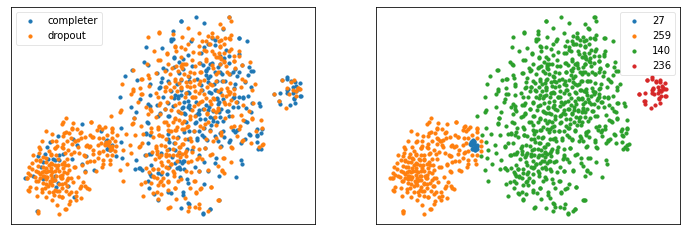

In [34]:
import matplotlib.pyplot as plt

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
x = [completer_coordinates[i][0] for i in range(0,len(completer_coordinates))]
y = [completer_coordinates[i][1] for i in range(0,len(completer_coordinates))]
ax1.scatter(x,y,s=10,label="completer")
x = [dropout_coordinates[i][0] for i in range(0,len(dropout_coordinates))]
y = [dropout_coordinates[i][1] for i in range(0,len(dropout_coordinates))]
ax1.scatter(x,y,s=10,label="dropout")
ax1.legend(framealpha=0.5)

ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
questionnaire_types_list = list(questionnaire_types.values())
for questionnaire_type in set(questionnaire_types.values()):
    x = [all_data_coordinates[i][0] for i in range(0,len(all_data_coordinates)) if questionnaire_types_list[i] == questionnaire_type] 
    y = [all_data_coordinates[i][1] for i in range(0,len(all_data_coordinates)) if questionnaire_types_list[i] == questionnaire_type]
    ax2.scatter(x,y,s=10,label=questionnaire_type)
ax2.legend(framealpha=0.5)
plt.show()